In [1]:
#
# attempt to automatically identify continuum channels

import numpy as np
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt
import astropy.io.fits as aiof
from spectral_cube import SpectralCube
import pyregion
import astropy.units as u

%matplotlib inline 
matplotlib.rcParams['axes.linewidth'] = 2.5
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 20

#f=aiof.open('test.fits')


In [26]:
# datafiles
mydir = '/Users/ltesti/Desktop/Dropbox/i16293_cubes/'
myproj = '00278'
myset = 'ACA_359'
mydir = '/Volumes/LT_Portable/iras_16293/img_'+myproj+'/'
cubes_root = 'cube_'+myproj+'_'+myset
cubes_nam = mydir+cubes_root+'_spw'
spws = ['0','1','2','3']
#spws = ['0','1','2','3','5','6','7','8']
myspw = spws[0]

#mydir='/Volumes/LT_2Tb/iras_16293/band4_sv/'
#spws = ['0']
#myproj = 'band4sv'
#myset = '140'
#cubes_root = 'cube_'+myproj+'_'+myset
#cubes_nam = mydir+cubes_root+'_spw'

# regions
source_a = '16:32:22.879, -24:28:36.468'
rad_a = 1.*u.arcsec
source_b = '16:32:22.607, -24:28:32.559'
rad_b = 0.5*u.arcsec

a_reg = pyregion.parse("FK5; circle("+source_a+","+str(rad_a.to(u.degree).value)+")")
b_reg = pyregion.parse("FK5; circle("+source_b+","+str(rad_b.to(u.degree).value)+")")

In [3]:
# read cube

mycube = cubes_nam+str(spws[0])+'.fits'
cube = SpectralCube.read(mycube)
sca = cube.subcube_from_ds9region(a_reg)
scag = sca.with_spectral_unit(u.GHz)
scb = cube.subcube_from_ds9region(b_reg)
scbg = scb.with_spectral_unit(u.GHz)

ya = sca.mean(axis=(1,2))
yb = scb.mean(axis=(1,2))
print('Len(ya)={0} Len(b)={1}'.format(len(ya.value),len(yb.value)))

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

Len(ya)=2048 Len(b)=2048


/Users/ltesti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:66: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/ltesti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:86: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/ltesti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:109: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/ltesti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:117: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Converged after 37 loops
Converged after 2 loops
44
0
49
Selected channels (myspec): 44~45;49~53;1091;1105;1108;1116;1125~1127;1135;1137~1140;1144~1145;1148;1150~1151;1153~1154;1157;1164;1174;1183~1184;1197;1623;1627~1628;1632~1634;1639;1776
Selected channels  (spec2): 0~22;29~41;48~53;55~62;65~101;113~130;132~140;149~156;171~188;191~210;220~252;257~259;269~291;298~313;327;339~363;373~386;397~422;424~434;436~444;451~457;463~468;485~499;503~508;515~524;532~538;540~542;551~579;585~595;599~602;609~620;627~633;640~705;714~748;755~798;814~849;855~885;892~949;954~974;981~983;994~996;1008~1010;1021~1030;1036~1052;1062~1072;1079~1192;1200~1204;1206~1219;1224~1267;1273~1285;1289~1290;1300~1303;1309~1315;1318~1325;1333~1346;1348~1356;1358~1359;1361~1363;1372~1382;1388~1389;1405;1457~1481;1483;1486~1498;1506~1520;1527;1539~1579;1590~1644;1653~1655;1657~1683;1686~1710;1722;1724~1745;1748~1750;1754;1756~1771;1777~1804;1806~1807;1811~1815;1818~1819;1821~1834;1839~1863;1873~1887;1893~1952;1961~1971;1

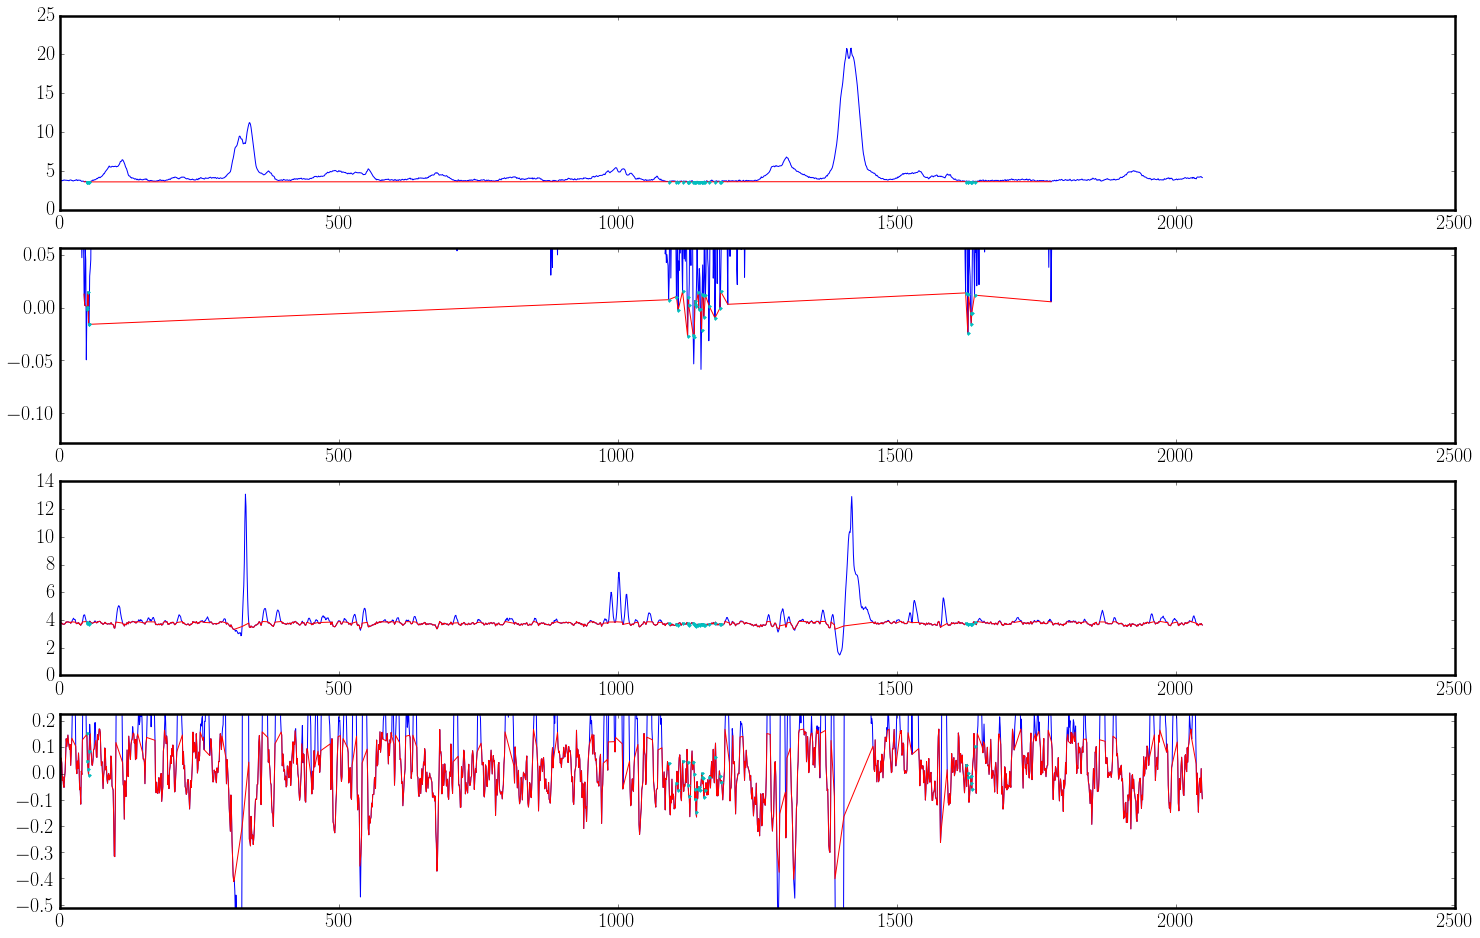

In [4]:
# identify cont chan
def get_cont_ch(myspec, sp=2., sm=2., doplot=False, spec2='none', sp2=2., sm2=2.):
    debug=False
    
    def get_casa_section(nv):
        n = nv[0]
        debug = True
        first = True
        sn = ''
        for nn in range(len(n)):
            if first:
                sn = sn+str(n[nn])
                if debug:
                    print(sn)
                snf = n[nn] 
                first = False
            else:
                if (n[nn]-nold > 1) or (n[nn] == n[-1]):
                    if snf == nold:
                        sn = sn+';'+str(n[nn])
                        #if debug:
                        #    print(sn)
                    else:
                        sn = sn+'~'+str(nold)+';'+str(n[nn])
                        #if debug:
                        #    print(sn)
                    snf = n[nn]
            nold=n[nn]
        return sn
    
    def get_common(nn1,nn2):
        #
        #nn1=tnn1[0]
        #nn2=tnn2[0]
        nc=[]
        for i in range(len(nn1)):
            j = 0
            while j < len(nn2):
                if nn1[i] == nn2[j]:
                    nc.append(nn1[i])
                    #if debug:
                    #    print("nn1={0}  nn2={1}  nc={2}".format(nn1[i],nn2[j],nc[-1]))
                    break
                j=j+1
        ncommon=len(nc)
        #if debug:
        #    print("len(nc)={0}".format(ncommon))
        nnc = np.zeros(ncommon,dtype=np.int)
        for i in range(ncommon):
            nnc[i]=np.int(nc[i])
            #if debug:
            #    print("nc[{0}]={1} nnc[{2}]={3}".format(i,nc[i],i,nnc[i]))
        return nnc
    
    def get_nn(yy,y,ssp,ssm):
        s = np.std(yy)
        m = np.median(yy)
        return np.where((y<(m+ssp*s))&(y>(m-ssm*s)))

    x = np.linspace(0,len(myspec),len(myspec))
    yy = np.copy(myspec)
    ylo = len(yy)
    ni = 0
    nmax = 200
    if doplot:
        if spec2 == 'none':
            fig, ax = plt.subplots(2, 1, sharex=False, sharey=False, squeeze=True, figsize=(18,16)) 
        else:
            fig, ax = plt.subplots(4, 1, sharex=False, sharey=False, squeeze=True, figsize=(25,16))
            ax[2].plot(x,spec2,color='b')
        ax[0].plot(x,myspec,color='b')
    while True:
        nn = get_nn(yy,myspec,sp,sm)
        yy = np.copy(myspec[nn])
        yl = len(yy)
        ni=ni+1
        if (yl == ylo):
            print("Converged after {0} loops".format(ni))
            break
        ylo = yl
        if (ni >= nmax):
            print("Reached max iterations: {0} loops".format(ni))
            break
    #
    # Estrae i canali "buoni" anche per spec2
    if spec2 != 'none':
        yy2 = np.copy(spec2)
        ylo2 = len(yy2)
        ni2 = 0
        while True:
            nn2 = get_nn(yy2,spec2,sp2,sm2)
            yy2 = np.copy(spec2[nn])
            yl2 = len(yy2)
            ni2=ni2+1
            if (yl2 == ylo2):
                print("Converged after {0} loops".format(ni2))
                break
            ylo2 = yl2
            if (ni2 >= nmax):
                print("Reached max iterations: {0} loops".format(ni2))
                break
    if doplot:
        ax[0].plot(x[nn],myspec[nn],color='r')
        ss = np.std(myspec[nn])
        m = np.mean(myspec[nn])
        ax[1].plot(x,myspec-m,color='b')
        ax[1].plot(x[nn],myspec[nn]-m,color='r')
        ax[1].set_ylim(-4.*sm*ss,4.*sp*ss)
        if spec2 != 'none':
            m2 = np.mean(spec2[nn2])
            ax[2].plot(x[nn2],spec2[nn2],color='r')
            ax[3].plot(x,spec2-m2,color='b')
            ax[3].plot(x[nn2],spec2[nn2]-m2,color='r')
            ax[3].set_ylim(-16.*sm*ss,16.*sp*ss)
    
    scc = get_casa_section(nn)
    if spec2 != 'none':
        scc2 = get_casa_section(nn2)
        nnc = get_common(nn[0],nn2[0])
        tnnc = (nnc,)
        ax[0].plot(x[tnnc],myspec[tnnc],'.',color='c')
        ax[1].plot(x[tnnc],myspec[tnnc]-m,'.',color='c')
        ax[2].plot(x[tnnc],spec2[tnnc],'.',color='c')
        ax[3].plot(x[tnnc],spec2[tnnc]-m2,'.',color='c')
        scc_c = get_casa_section(tnnc)
        if debug:
            print("                       nn : {0}".format(nn[0][0:10]))
            print("                      nn2 : {0}".format(nn2[0][0:10]))
            print("                      nnc : {0}".format(nnc[0:10]))
        return scc, scc2, scc_c
    else:
        return scc

cont_chan, cont_chan_2, cont_chan_c = get_cont_ch(ya.value,sp=1.1,sm=2.5,doplot=True,spec2=yb.value,sp2=1.1,sm2=2.5)
print("Selected channels (myspec): {0}".format(cont_chan))
print("Selected channels  (spec2): {0}".format(cont_chan_2))
print("           Common channels: {0}".format(cont_chan_c))

/Users/ltesti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:66: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/ltesti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:86: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/ltesti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:109: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/ltesti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:117: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Converged after 52 loops
Converged after 2 loops
203
1
203
Converged after 47 loops
Converged after 2 loops
11
0
33
Converged after 28 loops
Converged after 2 loops
31
1
31
Converged after 48 loops
Converged after 2 loops
14
1
14
0:203~205;210~211;214;216;290;293;299~300;304;309;504;507;519;532;541;557;560;565;568;570~571;574;635;642;650;653;658;660;664;667;673;675;686;690;825;827;837;1148~1149;1154;1163~1164;1167~1168;1172;1178~1179;1184;1235;1247;1249;1259~1260;1299;1306;1415;1539;1548;1639;1655;1657;1671;1892;1910;1944;1949;1951;1986;1992;2010;2013;2023;2037,1:33~37;43~47;51;53~56;58;64~65;67~69;72;75~78;114~116;274~275;277~283;285;292~295;299;302;387~389;392;394;743~744;746~747;749~752;754~756;758;830;832;836~838;840~843;846~848;851~854;856~868;871~872;876;878~879;881;883~884;941;943~951;958;979~981;984~985;989~991;1045~1047;1049;1051;1055;1083~1085;1094~1096;1099~1101;1180~1182;1188;1190~1191;1228~1229;1346~1347;1422;1426;1431~1435;1437;1439~1447;1449~1452;1458~1461;1696~1698;1701

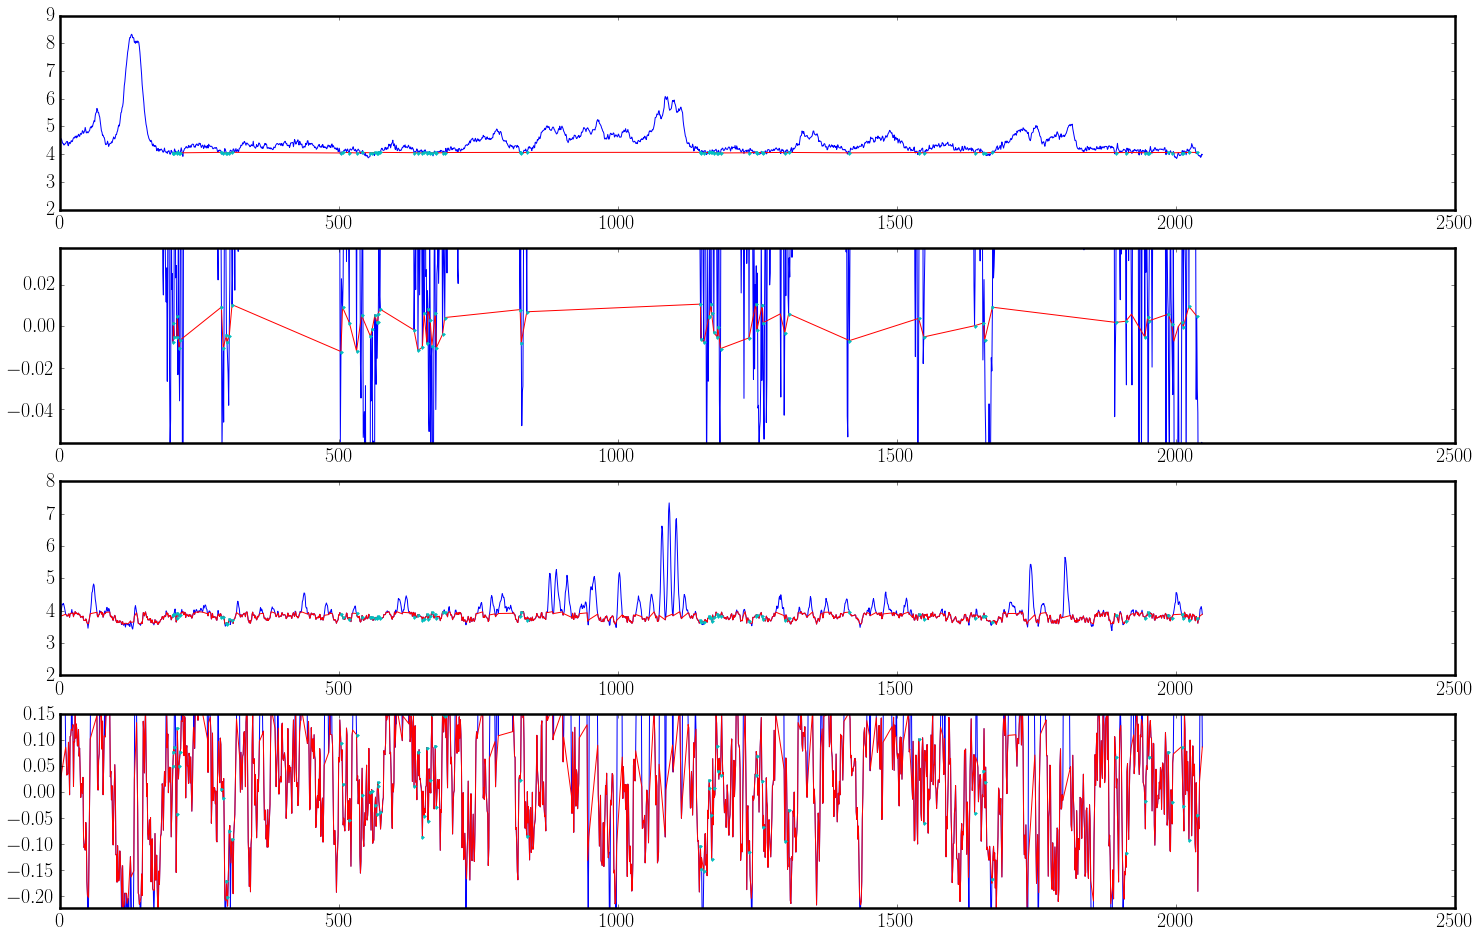

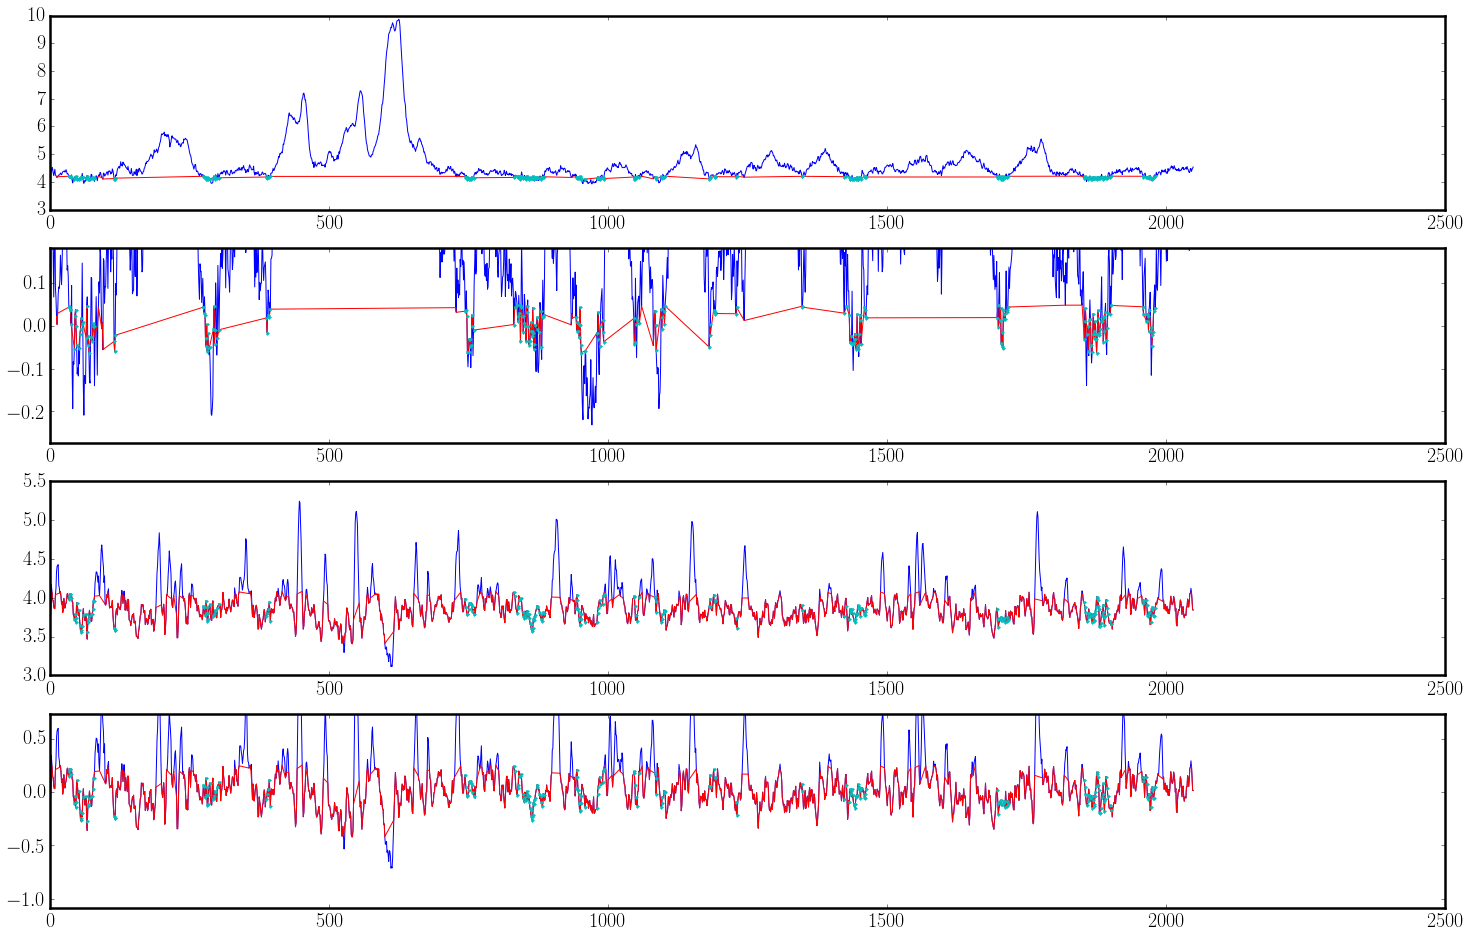

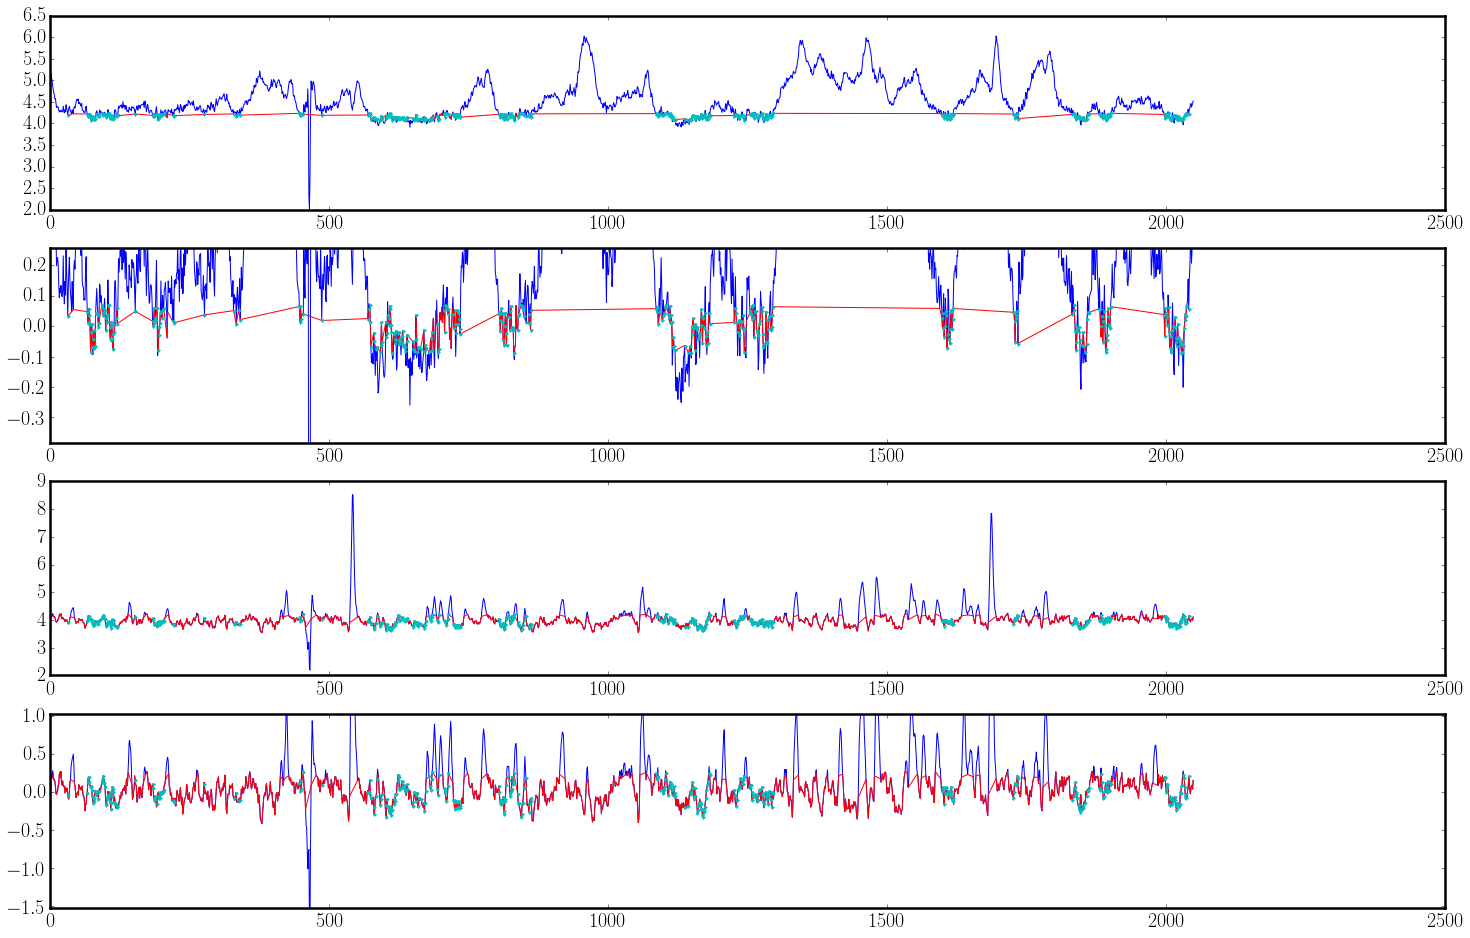

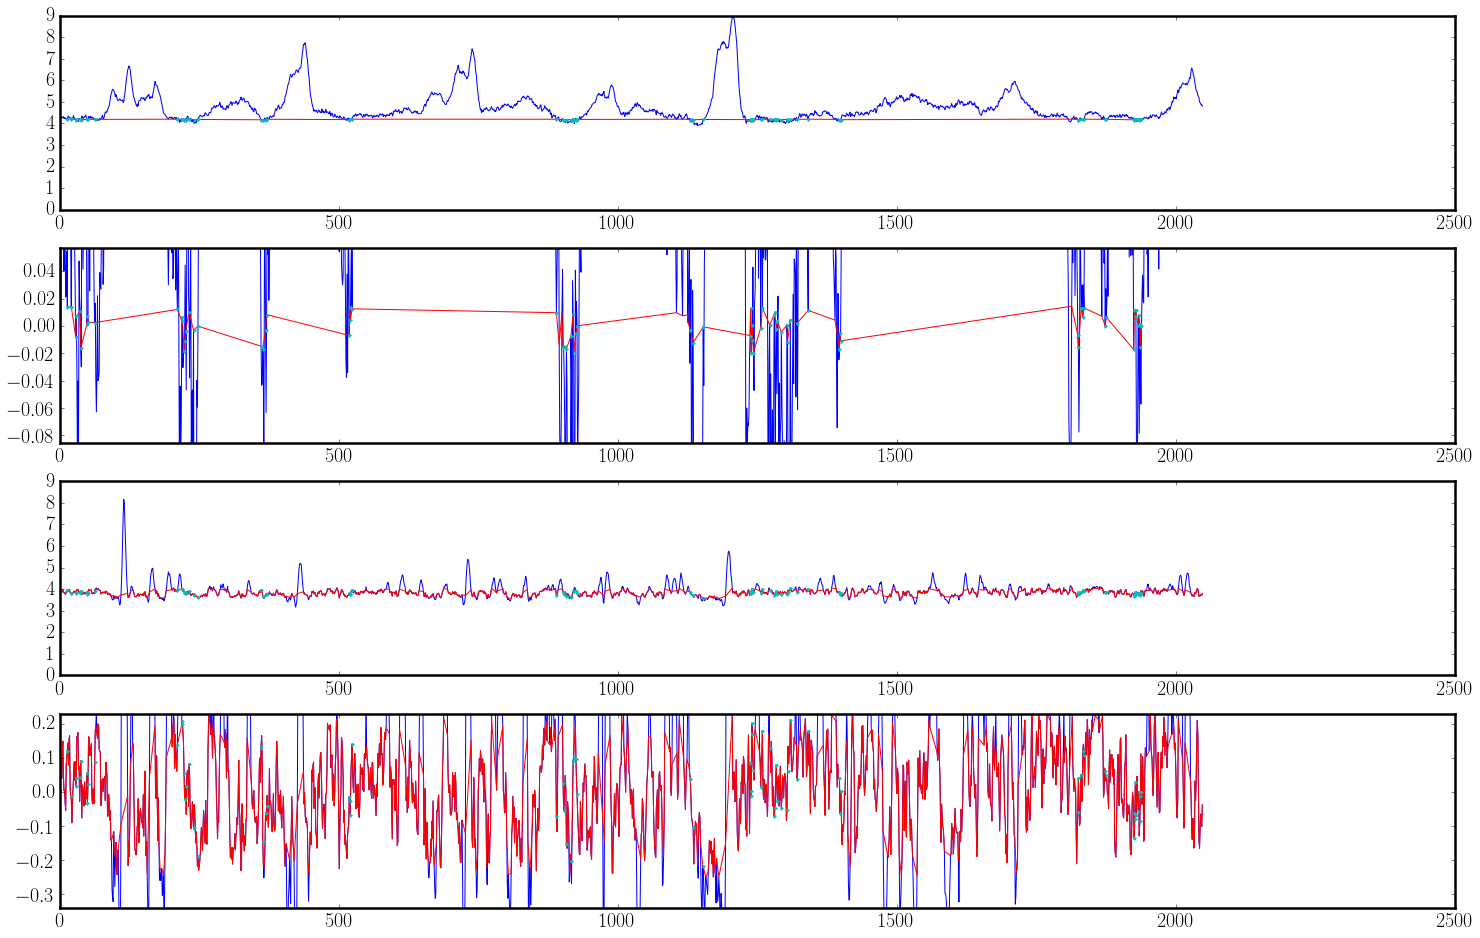

In [27]:
cont_all = ''
for myspw in spws:
    mycube = mydir+cubes_root+'_spw'+myspw+'.fits'
    cube = SpectralCube.read(mycube)
    sca = cube.subcube_from_ds9region(a_reg)
    scb = cube.subcube_from_ds9region(b_reg)
    ya = sca.mean(axis=(1,2))
    yb = scb.mean(axis=(1,2))
    # 
    # 090
    #cont_chan_1, cont_chan_2, cont_chan_c = get_cont_ch(ya.value,sp=2.,sm=2.,doplot=True,spec2=yb.value,sp2=2.,sm2=2.)
    # 
    # 240
    cont_chan_1, cont_chan_2, cont_chan_c = get_cont_ch(ya.value,sp=1.4,sm=2.1,doplot=True,spec2=yb.value,sp2=1.4,sm2=2.1)

    #cont_chan = get_cont_ch(ya,sp=1.35,sm=2.5,doplot=True)
    cont_all = cont_all+myspw+':'+cont_chan_c+','
    plt.savefig('fcontchan_'+cubes_root+'_spw'+myspw+'.pdf')

print(cont_all[0:-1])
